#  T-S Plot Verification


Created by Tore Hattermann

In [1]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cftime
import cmocean as cm

from netCDF4 import Dataset
import os.path
import matplotlib.colors as colors

Models: 
```
COCO   MITgcm-BAS          MITgcm-JPL  MOM6_SIGMA_ZSTAR  NEMO-CNRS      POP2x
FVCOM  MITgcm_BAS_Coupled  MOM6        MPAS-Ocean        NEMO-UKESM1is  ROMS-UTAS
```

In [2]:
# ## folder where the isomip-plus github repo is located
# baserepo = 'C:/thinf/github/isomip-plus/'
# ## folder where you downloaded the zipped Google Drive data
# basedrive = 'C:\Dropbox\Osci\ISOMIP\common_analysis\ISOMIP+Data 2/'

## folder where the isomip-plus github repo is located
baserepo = '/g/data/x77/cy8964/isomip-plus/'
## folder where you downloaded the zipped Google Drive data
basedrive = '/g/data/x77/cy8964/ISOMIP+Data-new/'

# load the data from the text files, which point to the right location of the file in the drive structure
Ocean0_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean0-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean1_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean1-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean2_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean2-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean0_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean0-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean1_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean1-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean2_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean2-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)

def get_labels(expt):
    '''
    Get labels of experiments
    Make some modifications to names
    '''
    labels = []
    for fileIndex in range(len(expt)):
        fileName = expt[fileIndex]
        baseName = os.path.basename(basedrive +fileName)
        modelName = ' '.join(baseName.split('_')[2:]).split('.')[0]
        if "COM" in fileName:
            #make edits to COM names
            if "MOM6" in fileName:
                if "SIGMA_ZSTAR" not in fileName:
                    modelName = modelName + '-LAYER'
            elif "ROMS" in fileName:
                modelName = "ROMS"
        elif "TYP" in fileName:
            # make edits to COM names
            if "MOM6" in fileName:
                modelName = modelName + '-LAYER'
            elif "CNRS" in fileName:
                if "TYPa" in fileName:
                    modelName = modelName + '-TYPa'
                elif "TYPb" in fileName:
                    modelName = modelName + '-TYPb'
            elif "tides" in fileName:
                modelName = "ROMS-tides"
            elif "ROMS" in fileName:
                modelName = "ROMS"
        labels.append(modelName.strip('V3').replace(" ", "-"))
    return labels


In [3]:
#12 model colours for 12 models, generated using https://colorbrewer2.org/#type=qualitative&scheme=Paired&n=12
modelcolours=['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']

# Gade Line assessment
When ice melts into seawater, the resulting water mass will cool and freshen at a constant ratio, causing water mass transformation along characteristic lines in temperature–salinity (T–S) space (Gade 1979). Neglecting corrections due to heat conduction at the ice–ocean interface (Asay-Davis et al. 2016), the slope of these lines is given as $\partial T / \partial S = L/(S_0c_w)$, with specific heat capacity of seawater $c_w = 3974 $ J kg−1K−1 and latent heat of fusion $L = 3.34 \times 10^5$ J kg−1 and salinity $S_0$ of the seawater that is being in contact with the ice, hera taken constant as $S_{ref} = 34.2$ from Asay-Davis 2016 for simplicity, but with insignificant impact on the results.

In absence of other freshwater sources or T–S end-members, Gade-line theory can be used to validate the water mass evolution of the ISOMIP+ ocean models, where water mass properties should be confined within the 

In [4]:
# Definitions
# Gade line
s0 = 34.2 # Sref from Aasay-Davis et al. 2016
sg = np.array([33, 34.75])
tg = np.array([-3, -3+3.34*10**5/(s0*3974)*(sg[1]-sg[0])])

# freezing point linearizaion, Tf = gamma_1 * S + gamma_2 + gamma_3 * P
lambda_1=-0.0573
lambda_2=0.0832
lambda_3=-7.53*10**-4
def tf(s0,p):
    return lambda_1*s0 + lambda_2 + lambda_3*p


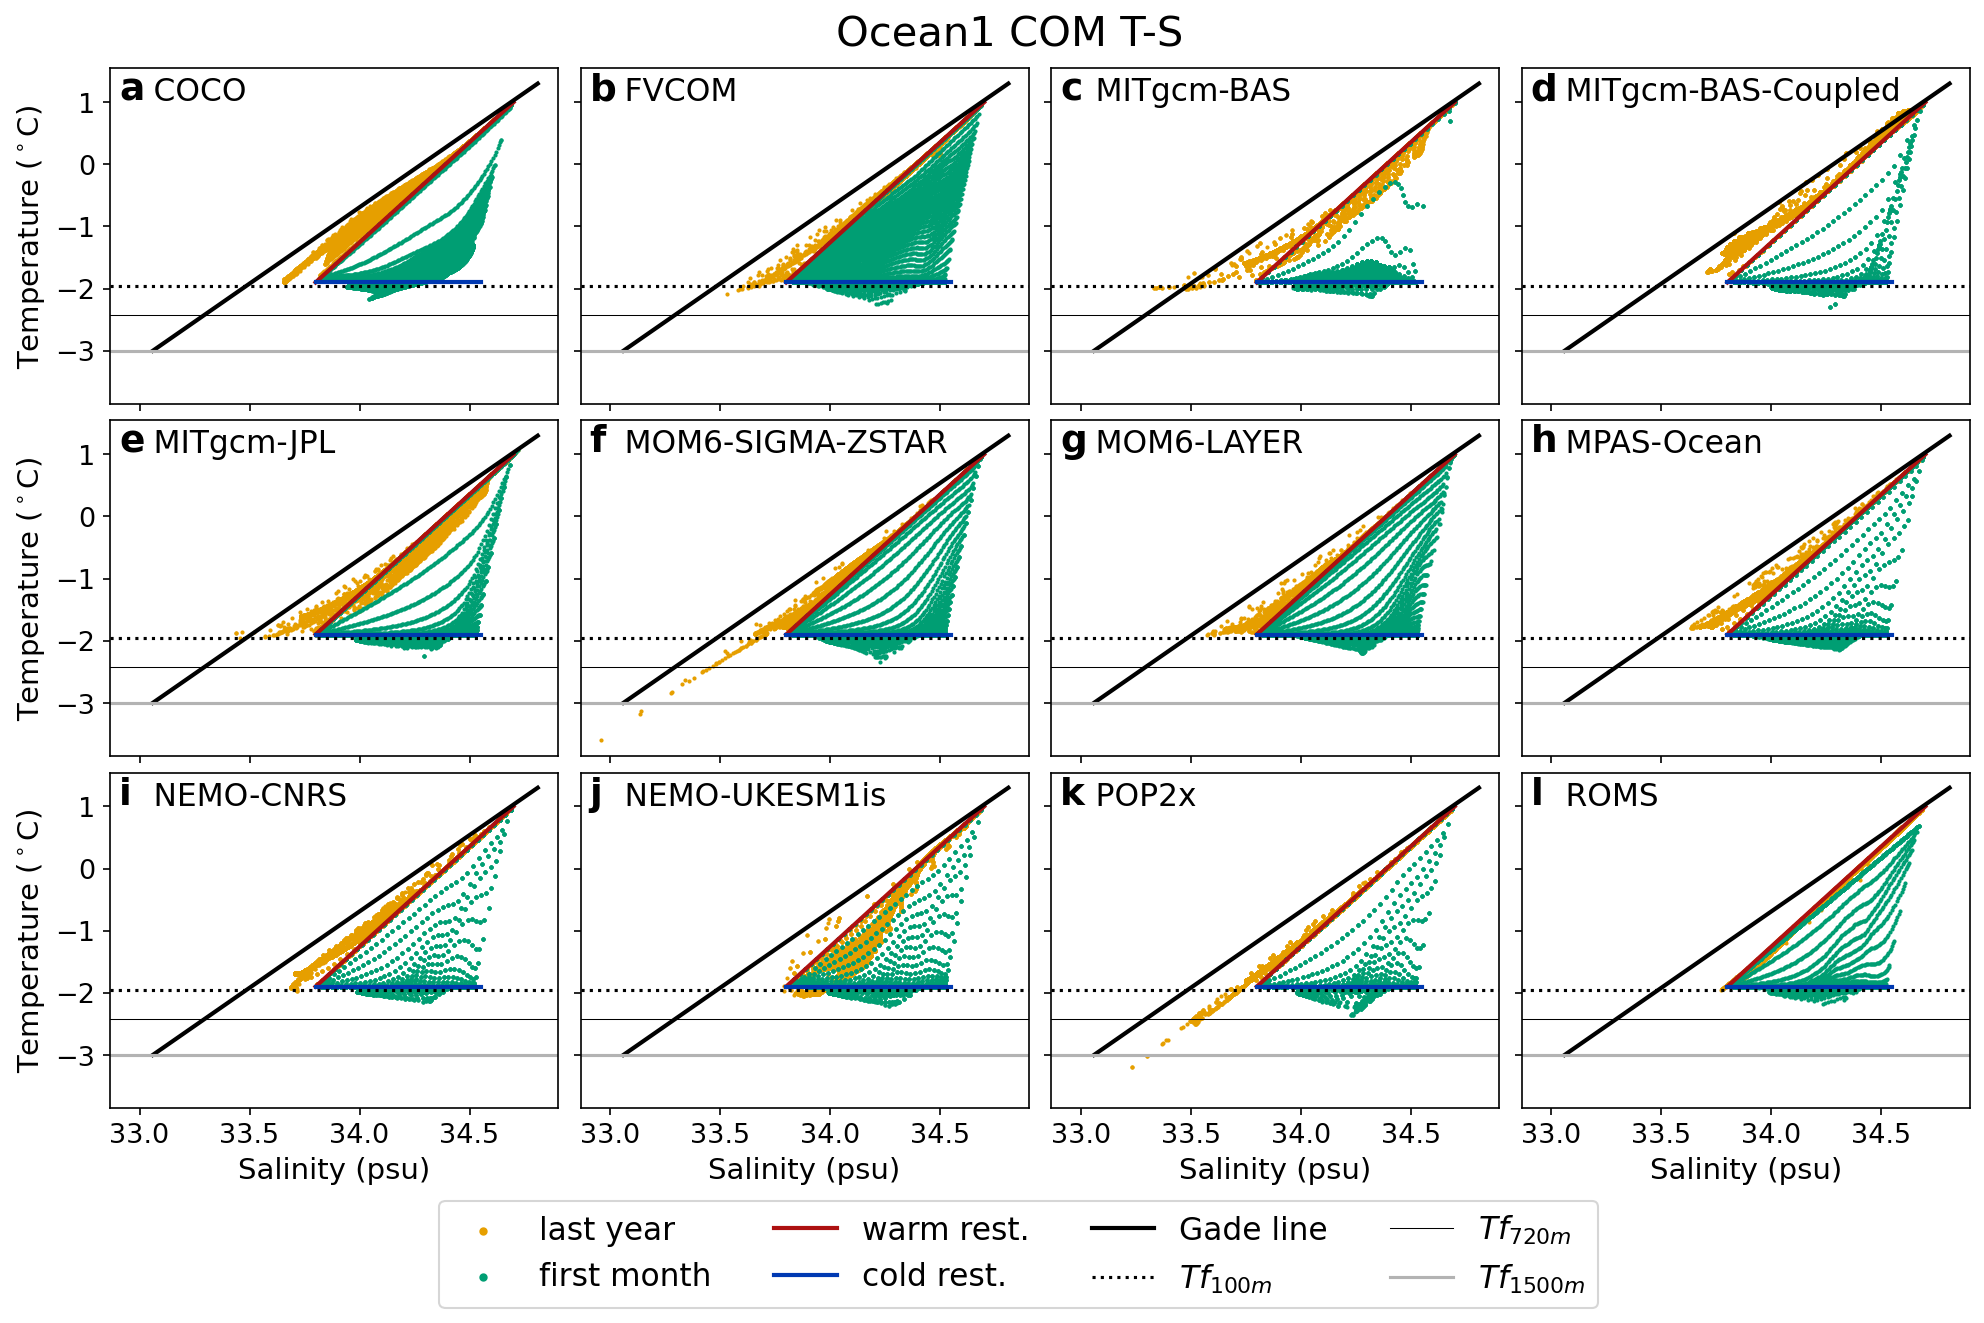

In [21]:
expt = Ocean1_COM

# cold restoring conditions
tc0 = -1.9
tc1 = -1.9
sc0 = 33.8
sc1 = 34.55

# warm restoring conditions
tw0 = -1.9
tw1 = 1
sw0 = 33.8
sw1 = 34.7

labels = get_labels(expt)

length = len(expt)
alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m']

fig, axes = plt.subplots(nrows = 3, ncols = 4, sharex=True, sharey=True, figsize=(16, 9),facecolor='w',dpi = 150)
for i in np.arange(length):
#for ax in axes.flat:
    ax = axes.flat[i]
    ds = xr.open_dataset(basedrive+expt[i], decode_times=False)
    # make x and y coordinates
    ds = ds.set_coords(['x', 'y', 'time', 'z'])
    nTime = ds.sizes['nTime']
    T0 = ds.temperatureXZ.isel(nTime=slice(0, 11)).mean('nTime')
    S0 = ds.salinityXZ.isel(nTime=slice(0, 11)).mean('nTime')
    T1 = ds.temperatureXZ.isel(nTime=slice(nTime-12, nTime)).mean('nTime')
    S1 = ds.salinityXZ.isel(nTime=slice(nTime-12, nTime)).mean('nTime')
    # T_XZ < 1e36 is to get rid of fill values.
    T0 = T0.where(T0 < 1e10)
    S0 = S0.where(S0 < 1e10)
    T1 = T1.where(T1 < 1e10)
    S1 = S1.where(S1 < 1e10)
    ax.scatter(
        S1,T1,
        color = '#E69F00', s = 1)
    ax.scatter(
        S1[0],T1[0],
        color = '#E69F00', label = 'last year', s = 1)
    ax.scatter(
        S0,T0,
        color = '#009E73', s = 1)
    ax.scatter(
        S0[0],T0[0],
        color = '#009E73', label = 'first month', s = 1)
    ax.plot(
        (sw0, sw1),(tw0, tw1),
        color = '#AD1111', label = 'warm rest.', linewidth = 2)
    ax.plot(
        (sc0, sc1),(tc0, tc1),
        color = '#0039B2', label = 'cold rest.', linewidth = 2)
    ax.plot(
        sg+0.06,tg,
        color = '#000000', label = 'Gade line', linewidth = 2)
    plt.sca(ax)
  #  plt.axhline(y = tf(s0,0), color = 'k', linestyle = ':', label = '$Tf_{surface}$')
    plt.axhline(y = tf(s0,100), color = 'k', linestyle = ':', label = '$Tf_{100m}$')
    plt.axhline(y = tf(s0,720), color = 'k', linestyle = '-', label = '$Tf_{720m}$', linewidth = 0.5)
    plt.axhline(y = tf(s0,1500), color = [0.7, 0.7, 0.7], linestyle = '-', label = '$Tf_{1500m}$')
    plt.text(0.02,0.99,alphabet[i], fontsize = 18, transform=ax.transAxes, fontweight='bold', va='top')
    plt.text(0.01,0.975,'    '+labels[i], fontsize = 15, transform=ax.transAxes, va='top')
    plt.tick_params(labelsize=13)
    #plt.xlim(33.1,34.9)
    #plt.text(33.5,  -3.5,  labels[i])
plt.legend(loc="upper left", fontsize = 15, bbox_to_anchor = (-2.45,-0.23), ncol = 4,markerscale=3.)
axes[0,0].set_ylabel('Temperature ($^\circ$C)', fontsize = 14)
axes[1,0].set_ylabel('Temperature ($^\circ$C)', fontsize = 14)
axes[2,0].set_ylabel('Temperature ($^\circ$C)', fontsize = 14)
axes[2,0].set_xlabel('Salinity (psu)', fontsize = 14)
axes[2,1].set_xlabel('Salinity (psu)', fontsize = 14)
axes[2,2].set_xlabel('Salinity (psu)', fontsize = 14)
axes[2,3].set_xlabel('Salinity (psu)', fontsize = 14)

#plt.savefig("gade_line_Ocean1_COM.png", bbox_inches='tight')
fig.subplots_adjust(hspace = 0.05,wspace = 0.05)
fig.suptitle('Ocean1 COM T-S', y=0.92,fontsize = 20);
plt.show()

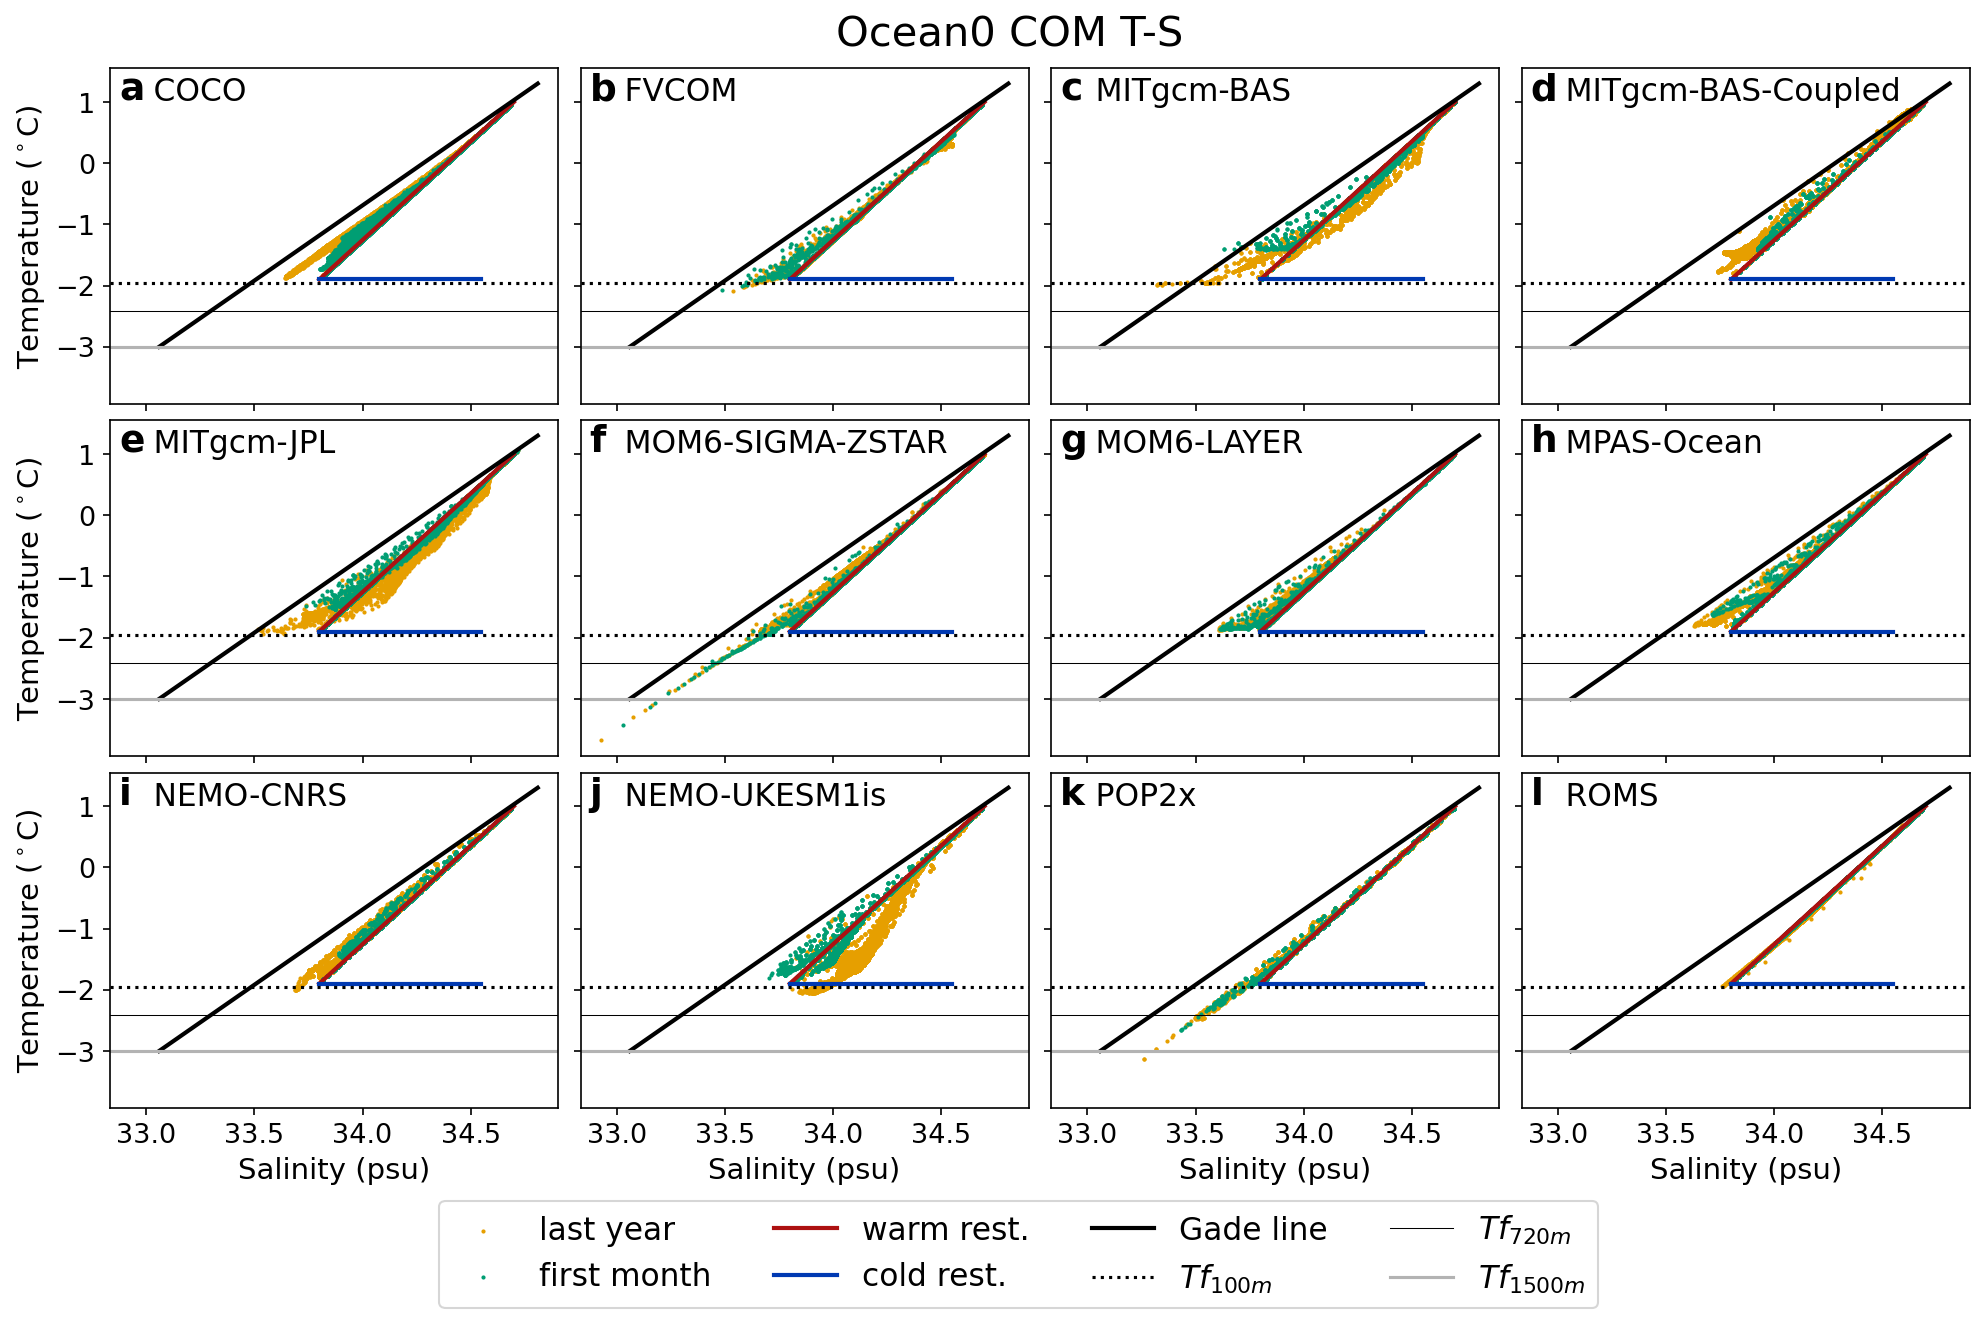

In [22]:
expt = Ocean0_COM

# cold restoring conditions
tc0 = -1.9
tc1 = -1.9
sc0 = 33.8
sc1 = 34.55

# warm restoring conditions
tw0 = -1.9
tw1 = 1
sw0 = 33.8
sw1 = 34.7

labels = get_labels(expt)

length = len(expt)
alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m']

fig, axes = plt.subplots(nrows = 3, ncols = 4, sharex=True, sharey=True, figsize=(16, 9),facecolor='w',dpi = 150)
for i in np.arange(length):
#for ax in axes.flat:
    ax = axes.flat[i]
    ds = xr.open_dataset(basedrive+expt[i], decode_times=False)
    # make x and y coordinates
    ds = ds.set_coords(['x', 'y', 'time', 'z'])
    nTime = ds.sizes['nTime']
    T0 = ds.temperatureXZ.isel(nTime=slice(0, 1)).mean('nTime')
    S0 = ds.salinityXZ.isel(nTime=slice(0, 1)).mean('nTime')
    T1 = ds.temperatureXZ.isel(nTime=slice(nTime-1, nTime)).mean('nTime')
    S1 = ds.salinityXZ.isel(nTime=slice(nTime-1, nTime)).mean('nTime')
    # T_XZ < 1e36 is to get rid of fill values.
    T0 = T0.where(T0 < 1e10)
    S0 = S0.where(S0 < 1e10)
    T1 = T1.where(T1 < 1e10)
    S1 = S1.where(S1 < 1e10)
    ax.scatter(
        S1,T1,
        color = '#E69F00', s = 1)
    ax.scatter(
        S1[0],T1[0],
        color = '#E69F00', label = 'last year', s = 1)
    ax.scatter(
        S0,T0,
        color = '#009E73', s = 1)
    ax.scatter(
        S0[0],T0[0],
        color = '#009E73', label = 'first month', s = 1)
    ax.plot(
        (sw0, sw1),(tw0, tw1),
        color = '#AD1111', label = 'warm rest.', linewidth = 2)
    ax.plot(
        (sc0, sc1),(tc0, tc1),
        color = '#0039B2', label = 'cold rest.', linewidth = 2)
    ax.plot(
        sg+0.06,tg,
        color = '#000000', label = 'Gade line', linewidth = 2)
    plt.sca(ax)
  #  plt.axhline(y = tf(s0,0), color = 'k', linestyle = ':', label = '$Tf_{surface}$')
    plt.axhline(y = tf(s0,100), color = 'k', linestyle = ':', label = '$Tf_{100m}$')
    plt.axhline(y = tf(s0,720), color = 'k', linestyle = '-', label = '$Tf_{720m}$', linewidth = 0.5)
    plt.axhline(y = tf(s0,1500), color = [0.7, 0.7, 0.7], linestyle = '-', label = '$Tf_{1500m}$')
    plt.text(0.02,0.99,alphabet[i], fontsize = 18, transform=ax.transAxes, fontweight='bold', va='top')
    plt.text(0.01,0.975,'    '+labels[i], fontsize = 15, transform=ax.transAxes, va='top')
    plt.tick_params(labelsize=13)
    #plt.text(33.5,  -3.5,  labels[i])
plt.legend(loc="upper left", fontsize = 15, bbox_to_anchor = (-2.45,-0.23), ncol = 4)
axes[0,0].set_ylabel('Temperature ($^\circ$C)', fontsize = 14)
axes[1,0].set_ylabel('Temperature ($^\circ$C)', fontsize = 14)
axes[2,0].set_ylabel('Temperature ($^\circ$C)', fontsize = 14)
axes[2,0].set_xlabel('Salinity (psu)', fontsize = 14)
axes[2,1].set_xlabel('Salinity (psu)', fontsize = 14)
axes[2,2].set_xlabel('Salinity (psu)', fontsize = 14)
axes[2,3].set_xlabel('Salinity (psu)', fontsize = 14)

#plt.savefig("gade_line_Ocean1_COM.png", bbox_inches='tight')
fig.subplots_adjust(hspace = 0.05,wspace = 0.05)
fig.suptitle('Ocean0 COM T-S', y=0.92,fontsize = 20);
plt.show()

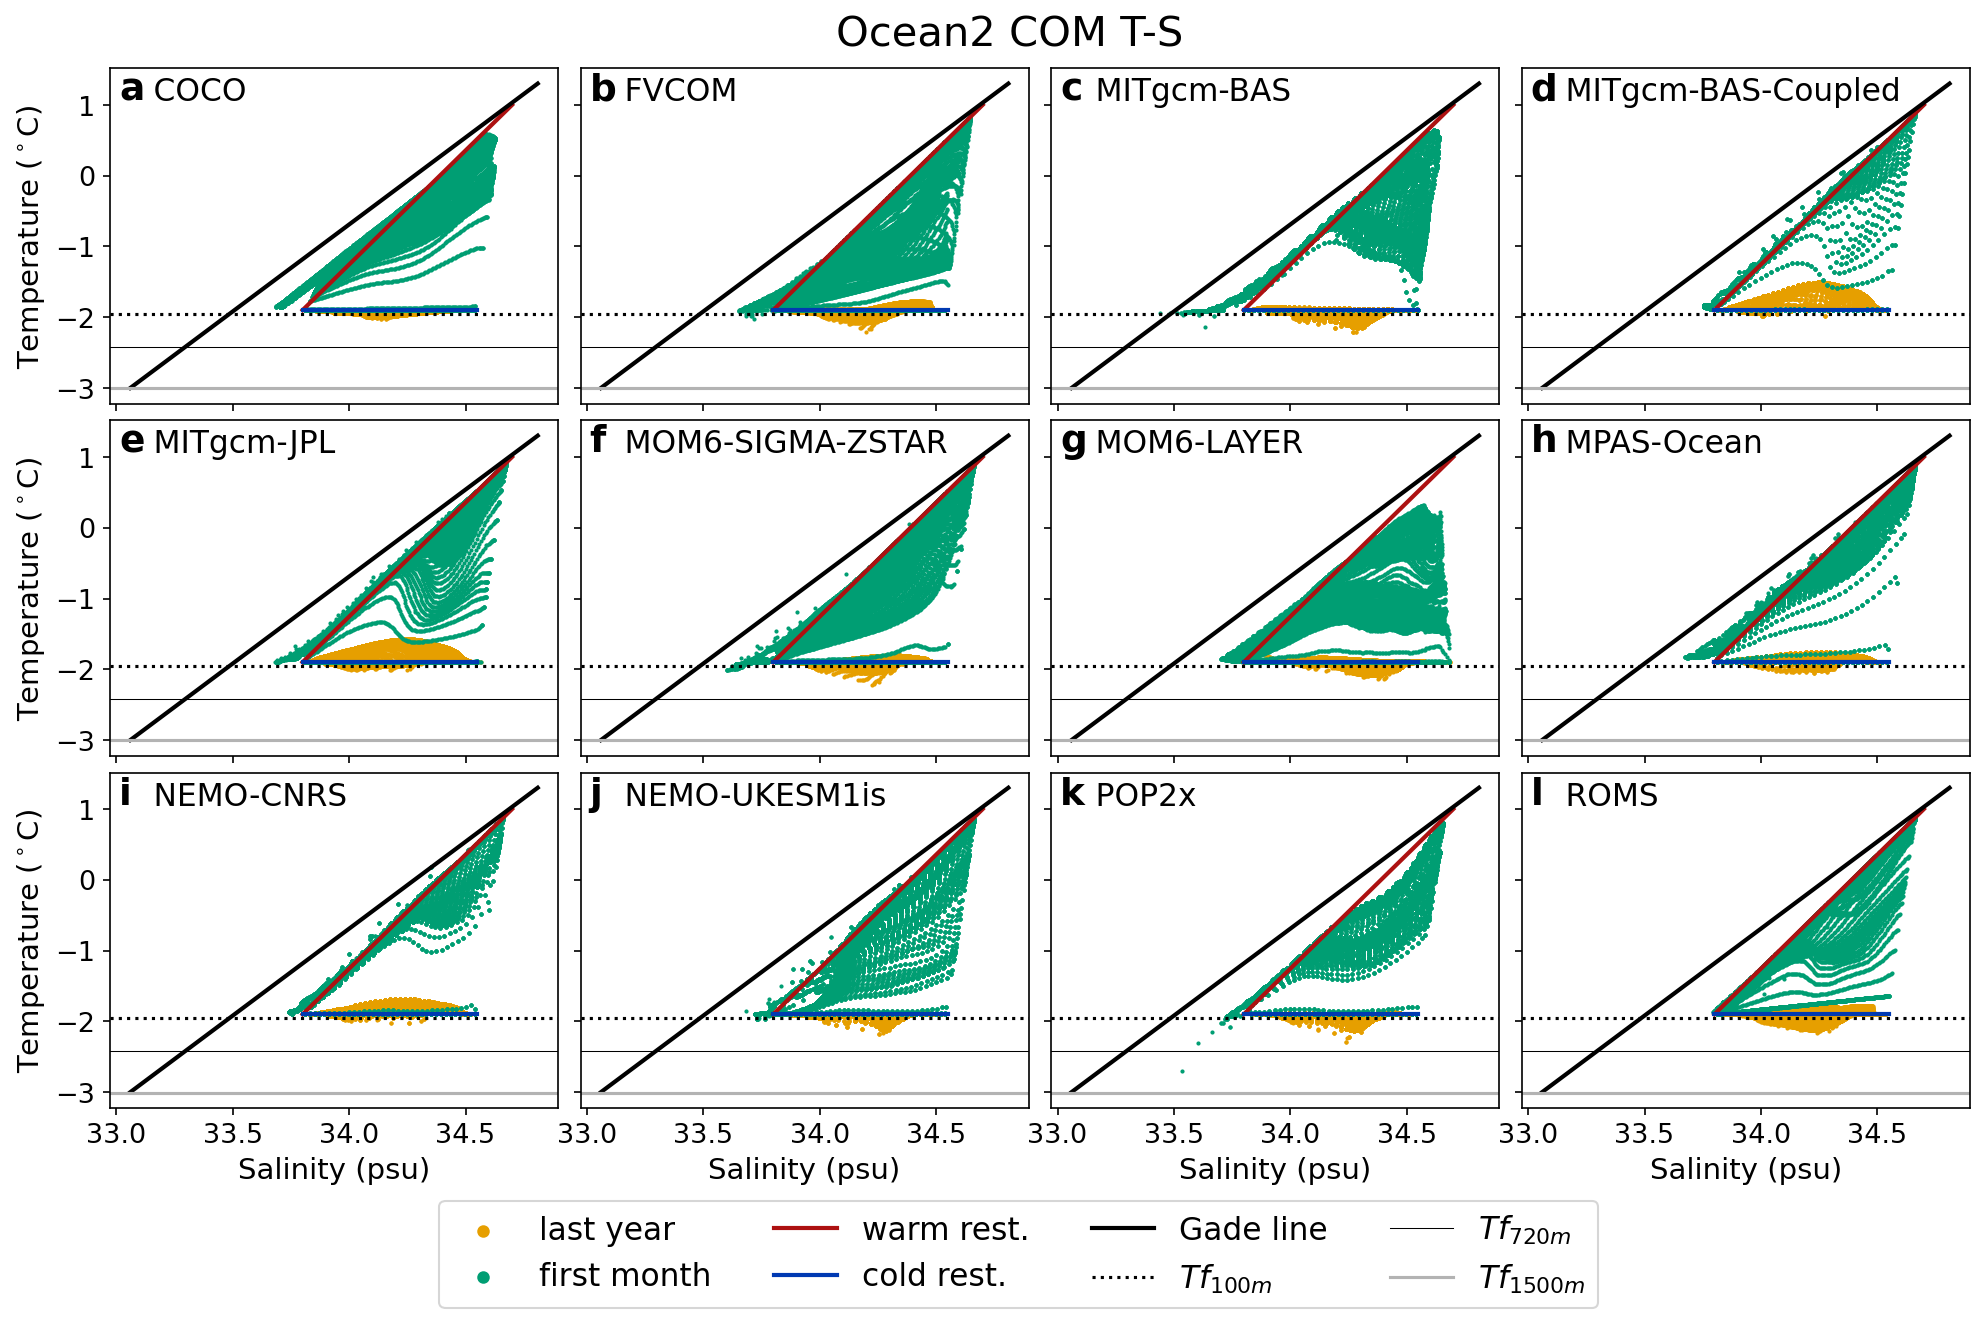

In [23]:
expt = Ocean2_COM

# cold restoring conditions
tc0 = -1.9
tc1 = -1.9
sc0 = 33.8
sc1 = 34.55

# warm restoring conditions
tw0 = -1.9
tw1 = 1
sw0 = 33.8
sw1 = 34.7

labels = get_labels(expt)
length = len(expt)
alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m']

fig, axes = plt.subplots(nrows = 3, ncols = 4, sharex=True, sharey=True, figsize=(16, 9),facecolor='w',dpi = 150)
for i in np.arange(length):
#for ax in axes.flat:
    ax = axes.flat[i]
    ds = xr.open_dataset(basedrive+expt[i], decode_times=False)
    # make x and y coordinates
    ds = ds.set_coords(['x', 'y', 'time', 'z'])
    nTime = ds.sizes['nTime']
    T0 = ds.temperatureXZ.isel(nTime=slice(0, 11)).mean('nTime')
    S0 = ds.salinityXZ.isel(nTime=slice(0, 11)).mean('nTime')
    T1 = ds.temperatureXZ.isel(nTime=slice(nTime-12, nTime)).mean('nTime')
    S1 = ds.salinityXZ.isel(nTime=slice(nTime-12, nTime)).mean('nTime')
    # T_XZ < 1e36 is to get rid of fill values.
    T0 = T0.where(T0 < 1e10)
    S0 = S0.where(S0 < 1e10)
    T1 = T1.where(T1 < 1e10)
    S1 = S1.where(S1 < 1e10)
    ax.scatter(
        S1,T1,
        color = '#E69F00', s = 1)
    ax.scatter(
        S1[0],T1[0],
        color = '#E69F00', label = 'last year', s = 1)
    ax.scatter(
        S0,T0,
        color = '#009E73', s = 1)
    ax.scatter(
        S0[0],T0[0],
        color = '#009E73', label = 'first month', s = 1)
    ax.plot(
        (sw0, sw1),(tw0, tw1),
        color = '#AD1111', label = 'warm rest.', linewidth = 2)
    ax.plot(
        (sc0, sc1),(tc0, tc1),
        color = '#0039B2', label = 'cold rest.', linewidth = 2)
    ax.plot(
        sg+0.06,tg,
        color = '#000000', label = 'Gade line', linewidth = 2)
    plt.sca(ax)
  #  plt.axhline(y = tf(s0,0), color = 'k', linestyle = ':', label = '$Tf_{surface}$')
    plt.axhline(y = tf(s0,100), color = 'k', linestyle = ':', label = '$Tf_{100m}$')
    plt.axhline(y = tf(s0,720), color = 'k', linestyle = '-', label = '$Tf_{720m}$', linewidth = 0.5)
    plt.axhline(y = tf(s0,1500), color = [0.7, 0.7, 0.7], linestyle = '-', label = '$Tf_{1500m}$')
    plt.text(0.02,0.99,alphabet[i], fontsize = 18, transform=ax.transAxes, fontweight='bold', va='top')
    plt.text(0.01,0.975,'    '+labels[i], fontsize = 15, transform=ax.transAxes, va='top')
    plt.tick_params(labelsize=13)
    #plt.text(33.5,  -3.5,  labels[i])
plt.legend(loc="upper left", fontsize = 15, bbox_to_anchor = (-2.45,-0.23), ncol = 4,markerscale=5.)
axes[0,0].set_ylabel('Temperature ($^\circ$C)', fontsize = 14)
axes[1,0].set_ylabel('Temperature ($^\circ$C)', fontsize = 14)
axes[2,0].set_ylabel('Temperature ($^\circ$C)', fontsize = 14)
axes[2,0].set_xlabel('Salinity (psu)', fontsize = 14)
axes[2,1].set_xlabel('Salinity (psu)', fontsize = 14)
axes[2,2].set_xlabel('Salinity (psu)', fontsize = 14)
axes[2,3].set_xlabel('Salinity (psu)', fontsize = 14)

# plt.savefig("gade_line_Ocean2_COM.png", bbox_inches='tight')
fig.subplots_adjust(hspace = 0.05,wspace = 0.05)
fig.suptitle('Ocean2 COM T-S', y=0.92,fontsize = 20);
plt.show()

colors from https://davidmathlogic.com/colorblind/#%23000000-%23E69F00-%2356B4E9-%23009E73-%23F0E442-%230039B2-%23D55E00-%23AD1111

# ZOOM INTO JUST ROMS

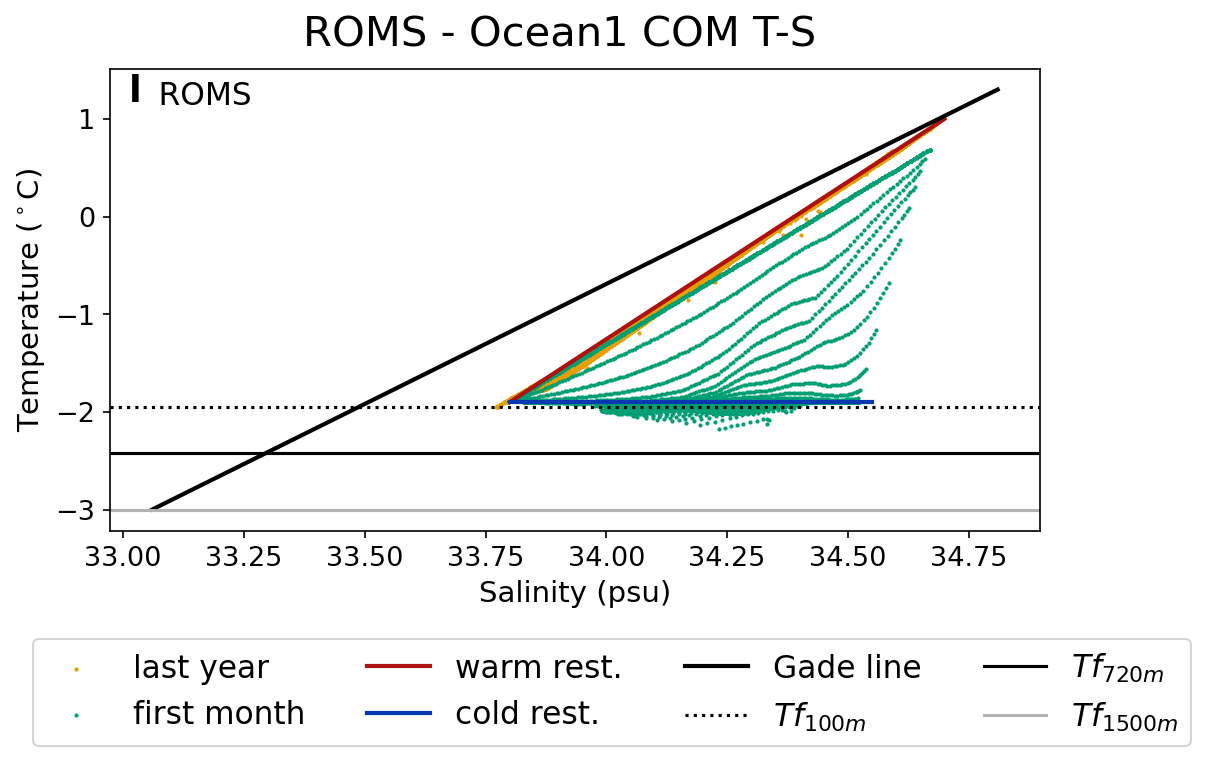

In [14]:
expt = Ocean1_COM

# cold restoring conditions
tc0 = -1.9
tc1 = -1.9
sc0 = 33.8
sc1 = 34.55

# warm restoring conditions
tw0 = -1.9
tw1 = 1
sw0 = 33.8
sw1 = 34.7

labels = get_labels(expt)

length = len(expt)
alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m']

fig, axes = plt.subplots(figsize=(8, 4),facecolor='w',dpi = 150)
for i in np.array([11]):
#for ax in axes.flat:
    ax = axes#.flat[i]
    ds = xr.open_dataset(basedrive+expt[i], decode_times=False)
    # make x and y coordinates
    ds = ds.set_coords(['x', 'y', 'time', 'z'])
    nTime = ds.sizes['nTime']
    T0 = ds.temperatureXZ.isel(nTime=slice(0, 11)).mean('nTime')
    S0 = ds.salinityXZ.isel(nTime=slice(0, 11)).mean('nTime')
    T1 = ds.temperatureXZ.isel(nTime=slice(nTime-12, nTime)).mean('nTime')
    S1 = ds.salinityXZ.isel(nTime=slice(nTime-12, nTime)).mean('nTime')
    # T_XZ < 1e36 is to get rid of fill values.
    T0 = T0.where(T0 < 1e10)
    S0 = S0.where(S0 < 1e10)
    T1 = T1.where(T1 < 1e10)
    S1 = S1.where(S1 < 1e10)
    ax.scatter(
        S1,T1,
        color = '#E69F00', s = 1)
    ax.scatter(
        S1[0],T1[0],
        color = '#E69F00', label = 'last year', s = 1)
    ax.scatter(
        S0,T0,
        color = '#009E73', s = 1)
    ax.scatter(
        S0[0],T0[0],
        color = '#009E73', label = 'first month', s = 1)
    ax.plot(
        (sw0, sw1),(tw0, tw1),
        color = '#AD1111', label = 'warm rest.', linewidth = 2)
    ax.plot(
        (sc0, sc1),(tc0, tc1),
        color = '#0039B2', label = 'cold rest.', linewidth = 2)
    ax.plot(
        sg+0.06,tg,
        color = '#000000', label = 'Gade line', linewidth = 2)
    plt.sca(ax)
  #  plt.axhline(y = tf(s0,0), color = 'k', linestyle = ':', label = '$Tf_{surface}$')
    plt.axhline(y = tf(s0,100), color = 'k', linestyle = ':', label = '$Tf_{100m}$')
    plt.axhline(y = tf(s0,720), color = 'k', linestyle = '-', label = '$Tf_{720m}$')
    plt.axhline(y = tf(s0,1500), color = [0.7, 0.7, 0.7], linestyle = '-', label = '$Tf_{1500m}$')
    plt.text(0.02,0.99,alphabet[i], fontsize = 18, transform=ax.transAxes, fontweight='bold', va='top')
    plt.text(0.01,0.975,'    '+labels[i], fontsize = 15, transform=ax.transAxes, va='top')
    plt.tick_params(labelsize=13)
    #plt.text(33.5,  -3.5,  labels[i])
plt.legend(loc="upper left", fontsize = 15, bbox_to_anchor = (-0.1,-0.2), ncol = 4)
axes.set_ylabel('Temperature ($^\circ$C)', fontsize = 14)
axes.set_xlabel('Salinity (psu)', fontsize = 14)

#plt.savefig("gade_line_Ocean1_COM.png", bbox_inches='tight')
fig.subplots_adjust(hspace = 0.05,wspace = 0.05)
fig.suptitle('ROMS - Ocean1 COM T-S', y=0.97,fontsize = 20);
plt.show()

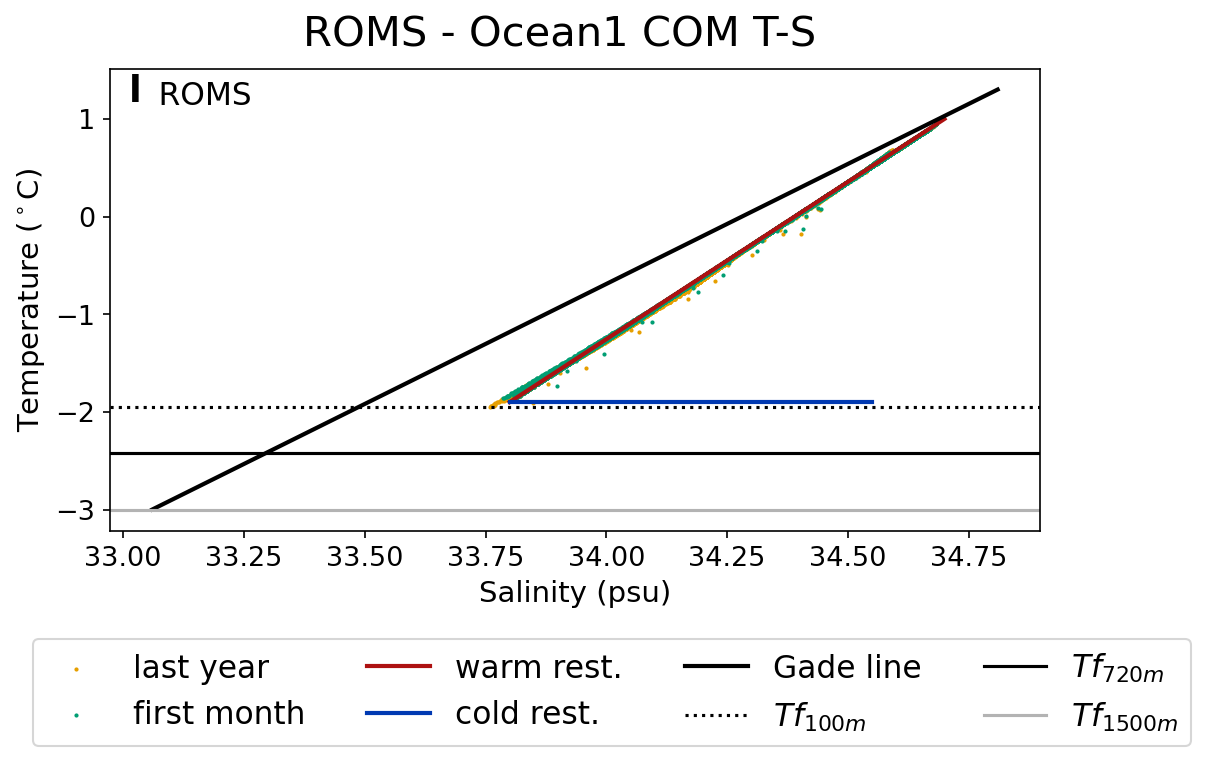

In [24]:
expt = Ocean0_COM

# cold restoring conditions
tc0 = -1.9
tc1 = -1.9
sc0 = 33.8
sc1 = 34.55

# warm restoring conditions
tw0 = -1.9
tw1 = 1
sw0 = 33.8
sw1 = 34.7

labels = get_labels(expt)

length = len(expt)
alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m']

fig, axes = plt.subplots(figsize=(8, 4),facecolor='w',dpi = 150)
for i in np.array([11]):
#for ax in axes.flat:
    ax = axes#.flat[i]
    ds = xr.open_dataset(basedrive+expt[i], decode_times=False)
    # make x and y coordinates
    ds = ds.set_coords(['x', 'y', 'time', 'z'])
    nTime = ds.sizes['nTime']
    T0 = ds.temperatureXZ.isel(nTime=slice(0, 11)).mean('nTime')
    S0 = ds.salinityXZ.isel(nTime=slice(0, 11)).mean('nTime')
    T1 = ds.temperatureXZ.isel(nTime=slice(nTime-12, nTime)).mean('nTime')
    S1 = ds.salinityXZ.isel(nTime=slice(nTime-12, nTime)).mean('nTime')
    # T_XZ < 1e36 is to get rid of fill values.
    T0 = T0.where(T0 < 1e10)
    S0 = S0.where(S0 < 1e10)
    T1 = T1.where(T1 < 1e10)
    S1 = S1.where(S1 < 1e10)
    ax.scatter(
        S1,T1,
        color = '#E69F00', s = 1)
    ax.scatter(
        S1[0],T1[0],
        color = '#E69F00', label = 'last year', s = 1)
    ax.scatter(
        S0,T0,
        color = '#009E73', s = 1)
    ax.scatter(
        S0[0],T0[0],
        color = '#009E73', label = 'first month', s = 1)
    ax.plot(
        (sw0, sw1),(tw0, tw1),
        color = '#AD1111', label = 'warm rest.', linewidth = 2)
    ax.plot(
        (sc0, sc1),(tc0, tc1),
        color = '#0039B2', label = 'cold rest.', linewidth = 2)
    ax.plot(
        sg+0.06,tg,
        color = '#000000', label = 'Gade line', linewidth = 2)
    plt.sca(ax)
  #  plt.axhline(y = tf(s0,0), color = 'k', linestyle = ':', label = '$Tf_{surface}$')
    plt.axhline(y = tf(s0,100), color = 'k', linestyle = ':', label = '$Tf_{100m}$')
    plt.axhline(y = tf(s0,720), color = 'k', linestyle = '-', label = '$Tf_{720m}$')
    plt.axhline(y = tf(s0,1500), color = [0.7, 0.7, 0.7], linestyle = '-', label = '$Tf_{1500m}$')
    plt.text(0.02,0.99,alphabet[i], fontsize = 18, transform=ax.transAxes, fontweight='bold', va='top')
    plt.text(0.01,0.975,'    '+labels[i], fontsize = 15, transform=ax.transAxes, va='top')
    plt.tick_params(labelsize=13)
    #plt.text(33.5,  -3.5,  labels[i])
plt.legend(loc="upper left", fontsize = 15, bbox_to_anchor = (-0.1,-0.2), ncol = 4)
axes.set_ylabel('Temperature ($^\circ$C)', fontsize = 14)
axes.set_xlabel('Salinity (psu)', fontsize = 14)

#plt.savefig("gade_line_Ocean1_COM.png", bbox_inches='tight')
fig.subplots_adjust(hspace = 0.05,wspace = 0.05)
fig.suptitle('ROMS - Ocean1 COM T-S', y=0.97,fontsize = 20);
plt.show()

# Below: Add T-Tf correction to gradient

Gade (1979) Eqn. 25 is

$$ \frac{dT}{dS} = S^{-1}[T-T_b + c_i/c_w(T_b-T_i)+L/C_w]$$

where $T_b$ is freezing point at ice ocean boundary. $T_i$ is temp of ice, ignoring conduction into ice this term goes away:

$$ \frac{dT}{dS} = S^{-1}[T-T_b + L/C_w]$$

From Jenkins (2007) I take it that T is the far field temperature and S is the far field salinity (but we have been using reference salinity). There is a whole range of water masses that could be the far field T and S so I am taking the T to be the +1 degree limit.

In [4]:
3.34*10**5/3974

84.0463009562154

In [6]:
# Definitions
# Gade line
s0 = 34.2 # Sref from Aasay-Davis et al. 2016
#sg = np.array([33, 34.75])
#tg = np.array([-3, -3+(3.34*10**5/3974 + )/s0*(sg[1]-sg[0])])

def gade_slope(T,s0,p):
    return 1/s0*(T-tf(s0,p)+3.34*10**5/3974)

# freezing point linearizaion, Tf = gamma_1 * S + gamma_2 + gamma_3 * P
lambda_1=-0.0573
lambda_2=0.0832
lambda_3=-7.53*10**-4
def tf(s0,p):
    return lambda_1*s0 + lambda_2 + lambda_3*p

print(gade_slope(-2,34.2,100))
print(gade_slope(1,34.2,100)) #what should T be? T at origin?
print(gade_slope(1,34.2,500)) #what should T be? T at origin?
print(gade_slope(1,33.8,360)) #what should T be? T at origin?
print(gade_slope(1,34.7,360)) #what should T be? T at origin?

# define ends of Gade line
sg = np.array([33,34.75])
# pass through T=1, S = 34.7
tg = (sg-34.7)*gade_slope(1,34.2,360)+1
print(tg)

2.4560836536905084
2.5438029519361227
2.5526099694799824
2.5790213300655447
2.5136164540696084
[-3.33419677  1.12747638]


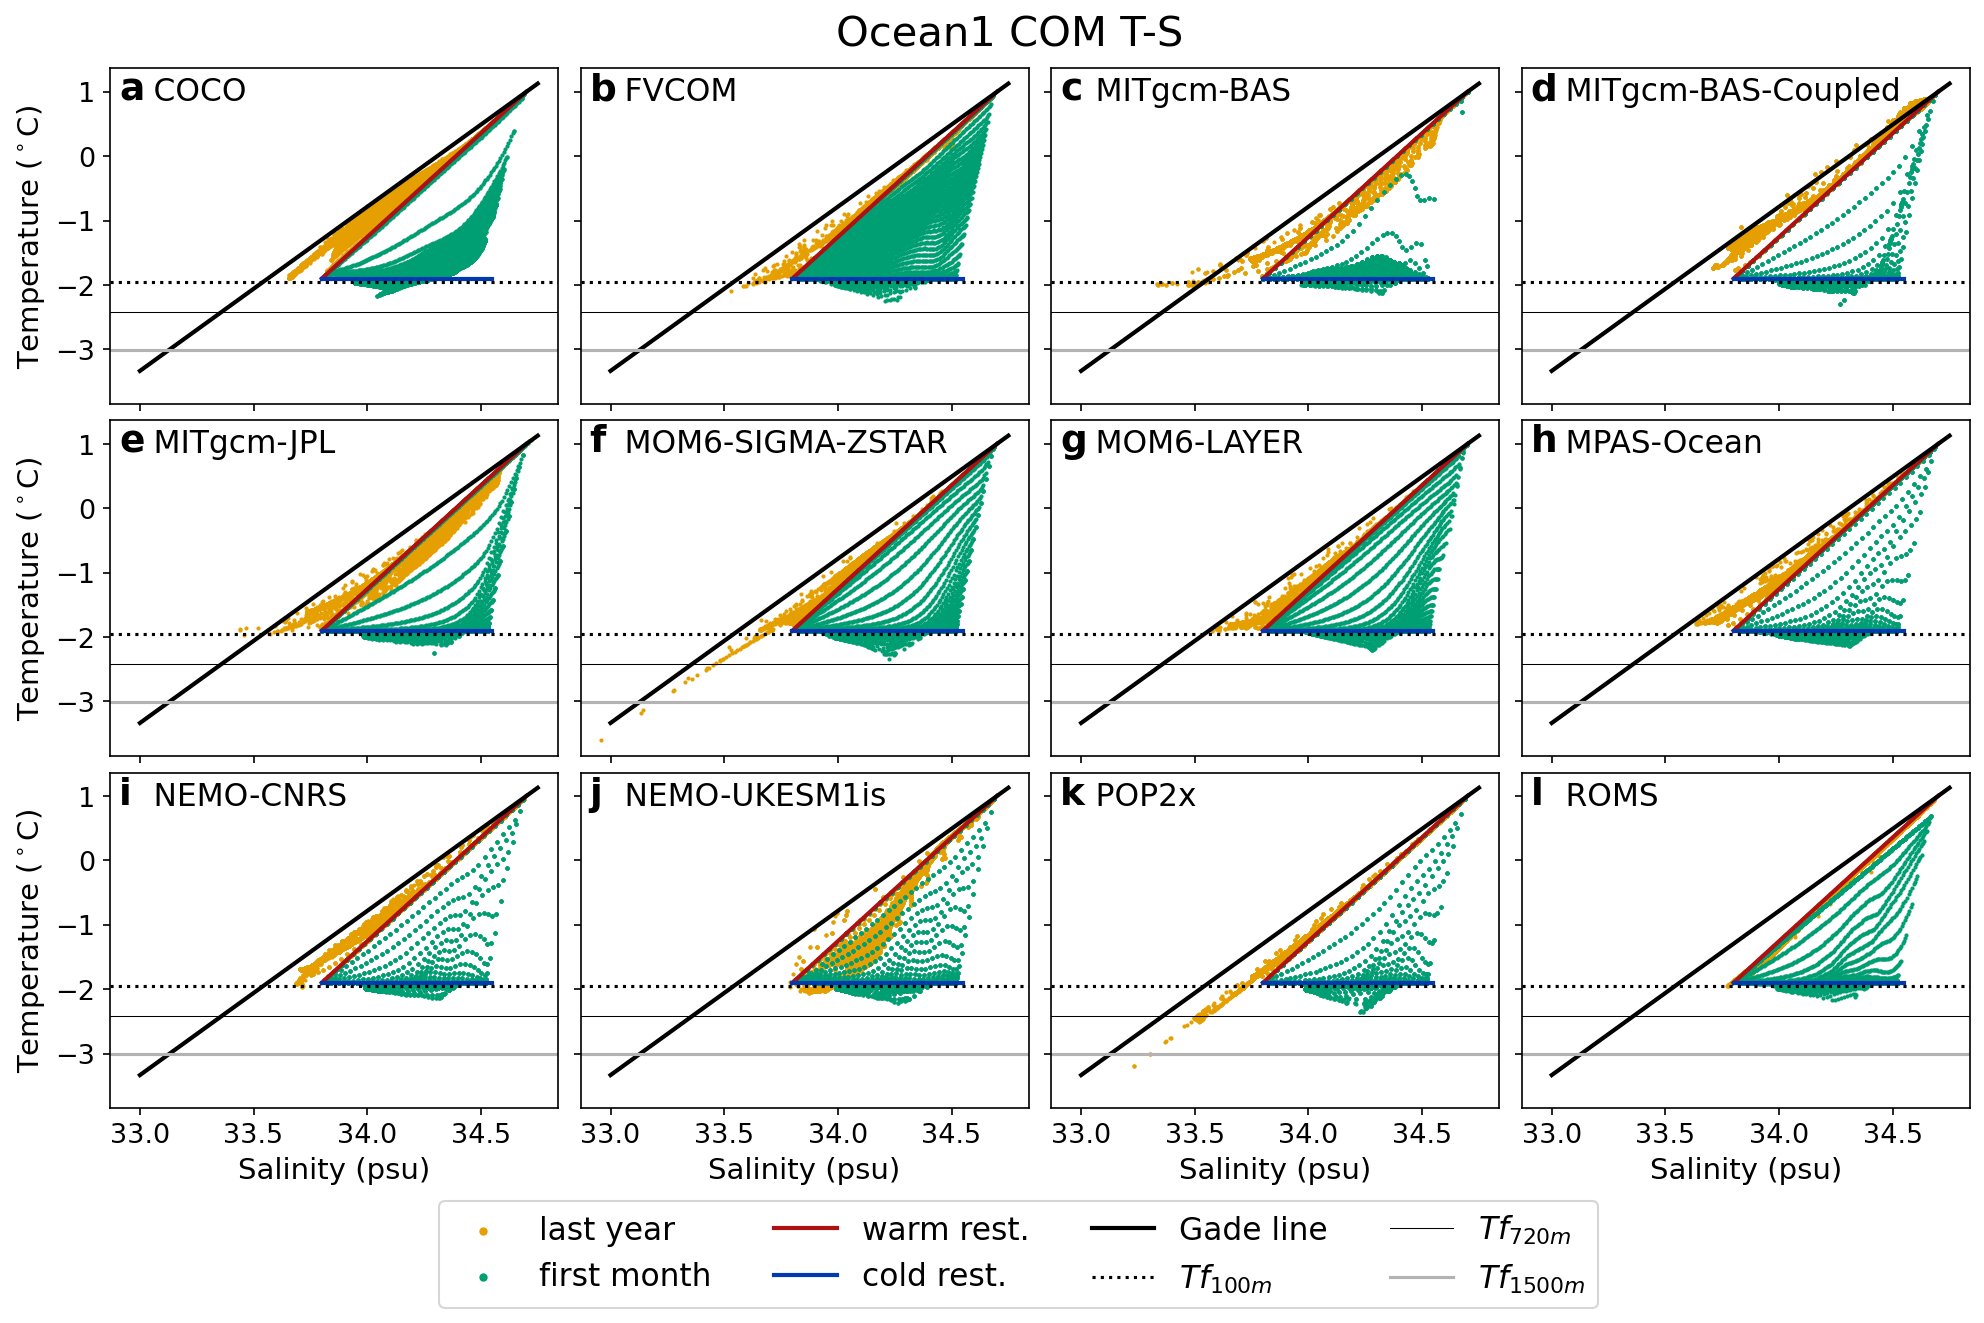

In [7]:
expt = Ocean1_COM

# cold restoring conditions
tc0 = -1.9
tc1 = -1.9
sc0 = 33.8
sc1 = 34.55

# warm restoring conditions
tw0 = -1.9
tw1 = 1
sw0 = 33.8
sw1 = 34.7

labels = get_labels(expt)

length = len(expt)
alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m']

fig, axes = plt.subplots(nrows = 3, ncols = 4, sharex=True, sharey=True, figsize=(16, 9),facecolor='w',dpi = 150)
for i in np.arange(length):
#for ax in axes.flat:
    ax = axes.flat[i]
    ds = xr.open_dataset(basedrive+expt[i], decode_times=False)
    # make x and y coordinates
    ds = ds.set_coords(['x', 'y', 'time', 'z'])
    nTime = ds.sizes['nTime']
    T0 = ds.temperatureXZ.isel(nTime=slice(0, 11)).mean('nTime')
    S0 = ds.salinityXZ.isel(nTime=slice(0, 11)).mean('nTime')
    T1 = ds.temperatureXZ.isel(nTime=slice(nTime-12, nTime)).mean('nTime')
    S1 = ds.salinityXZ.isel(nTime=slice(nTime-12, nTime)).mean('nTime')
    # T_XZ < 1e36 is to get rid of fill values.
    T0 = T0.where(T0 < 1e10)
    S0 = S0.where(S0 < 1e10)
    T1 = T1.where(T1 < 1e10)
    S1 = S1.where(S1 < 1e10)
    ax.scatter(
        S1,T1,
        color = '#E69F00', s = 1)
    ax.scatter(
        S1[0],T1[0],
        color = '#E69F00', label = 'last year', s = 1)
    ax.scatter(
        S0,T0,
        color = '#009E73', s = 1)
    ax.scatter(
        S0[0],T0[0],
        color = '#009E73', label = 'first month', s = 1)
    ax.plot(
        (sw0, sw1),(tw0, tw1),
        color = '#AD1111', label = 'warm rest.', linewidth = 2)
    ax.plot(
        (sc0, sc1),(tc0, tc1),
        color = '#0039B2', label = 'cold rest.', linewidth = 2)
    ax.plot(
        sg,tg,
        color = '#000000', label = 'Gade line', linewidth = 2)
    plt.sca(ax)
  #  plt.axhline(y = tf(s0,0), color = 'k', linestyle = ':', label = '$Tf_{surface}$')
    plt.axhline(y = tf(s0,100), color = 'k', linestyle = ':', label = '$Tf_{100m}$')
    plt.axhline(y = tf(s0,720), color = 'k', linestyle = '-', label = '$Tf_{720m}$', linewidth = 0.5)
    plt.axhline(y = tf(s0,1500), color = [0.7, 0.7, 0.7], linestyle = '-', label = '$Tf_{1500m}$')
    plt.text(0.02,0.99,alphabet[i], fontsize = 18, transform=ax.transAxes, fontweight='bold', va='top')
    plt.text(0.01,0.975,'    '+labels[i], fontsize = 15, transform=ax.transAxes, va='top')
    plt.tick_params(labelsize=13)
    #plt.xlim(33.1,34.9)
    #plt.text(33.5,  -3.5,  labels[i])
plt.legend(loc="upper left", fontsize = 15, bbox_to_anchor = (-2.45,-0.23), ncol = 4,markerscale=3.)
axes[0,0].set_ylabel('Temperature ($^\circ$C)', fontsize = 14)
axes[1,0].set_ylabel('Temperature ($^\circ$C)', fontsize = 14)
axes[2,0].set_ylabel('Temperature ($^\circ$C)', fontsize = 14)
axes[2,0].set_xlabel('Salinity (psu)', fontsize = 14)
axes[2,1].set_xlabel('Salinity (psu)', fontsize = 14)
axes[2,2].set_xlabel('Salinity (psu)', fontsize = 14)
axes[2,3].set_xlabel('Salinity (psu)', fontsize = 14)

#plt.savefig("gade_line_Ocean1_COM.png", bbox_inches='tight')
fig.subplots_adjust(hspace = 0.05,wspace = 0.05)
fig.suptitle('Ocean1 COM T-S', y=0.92,fontsize = 20);
plt.show()

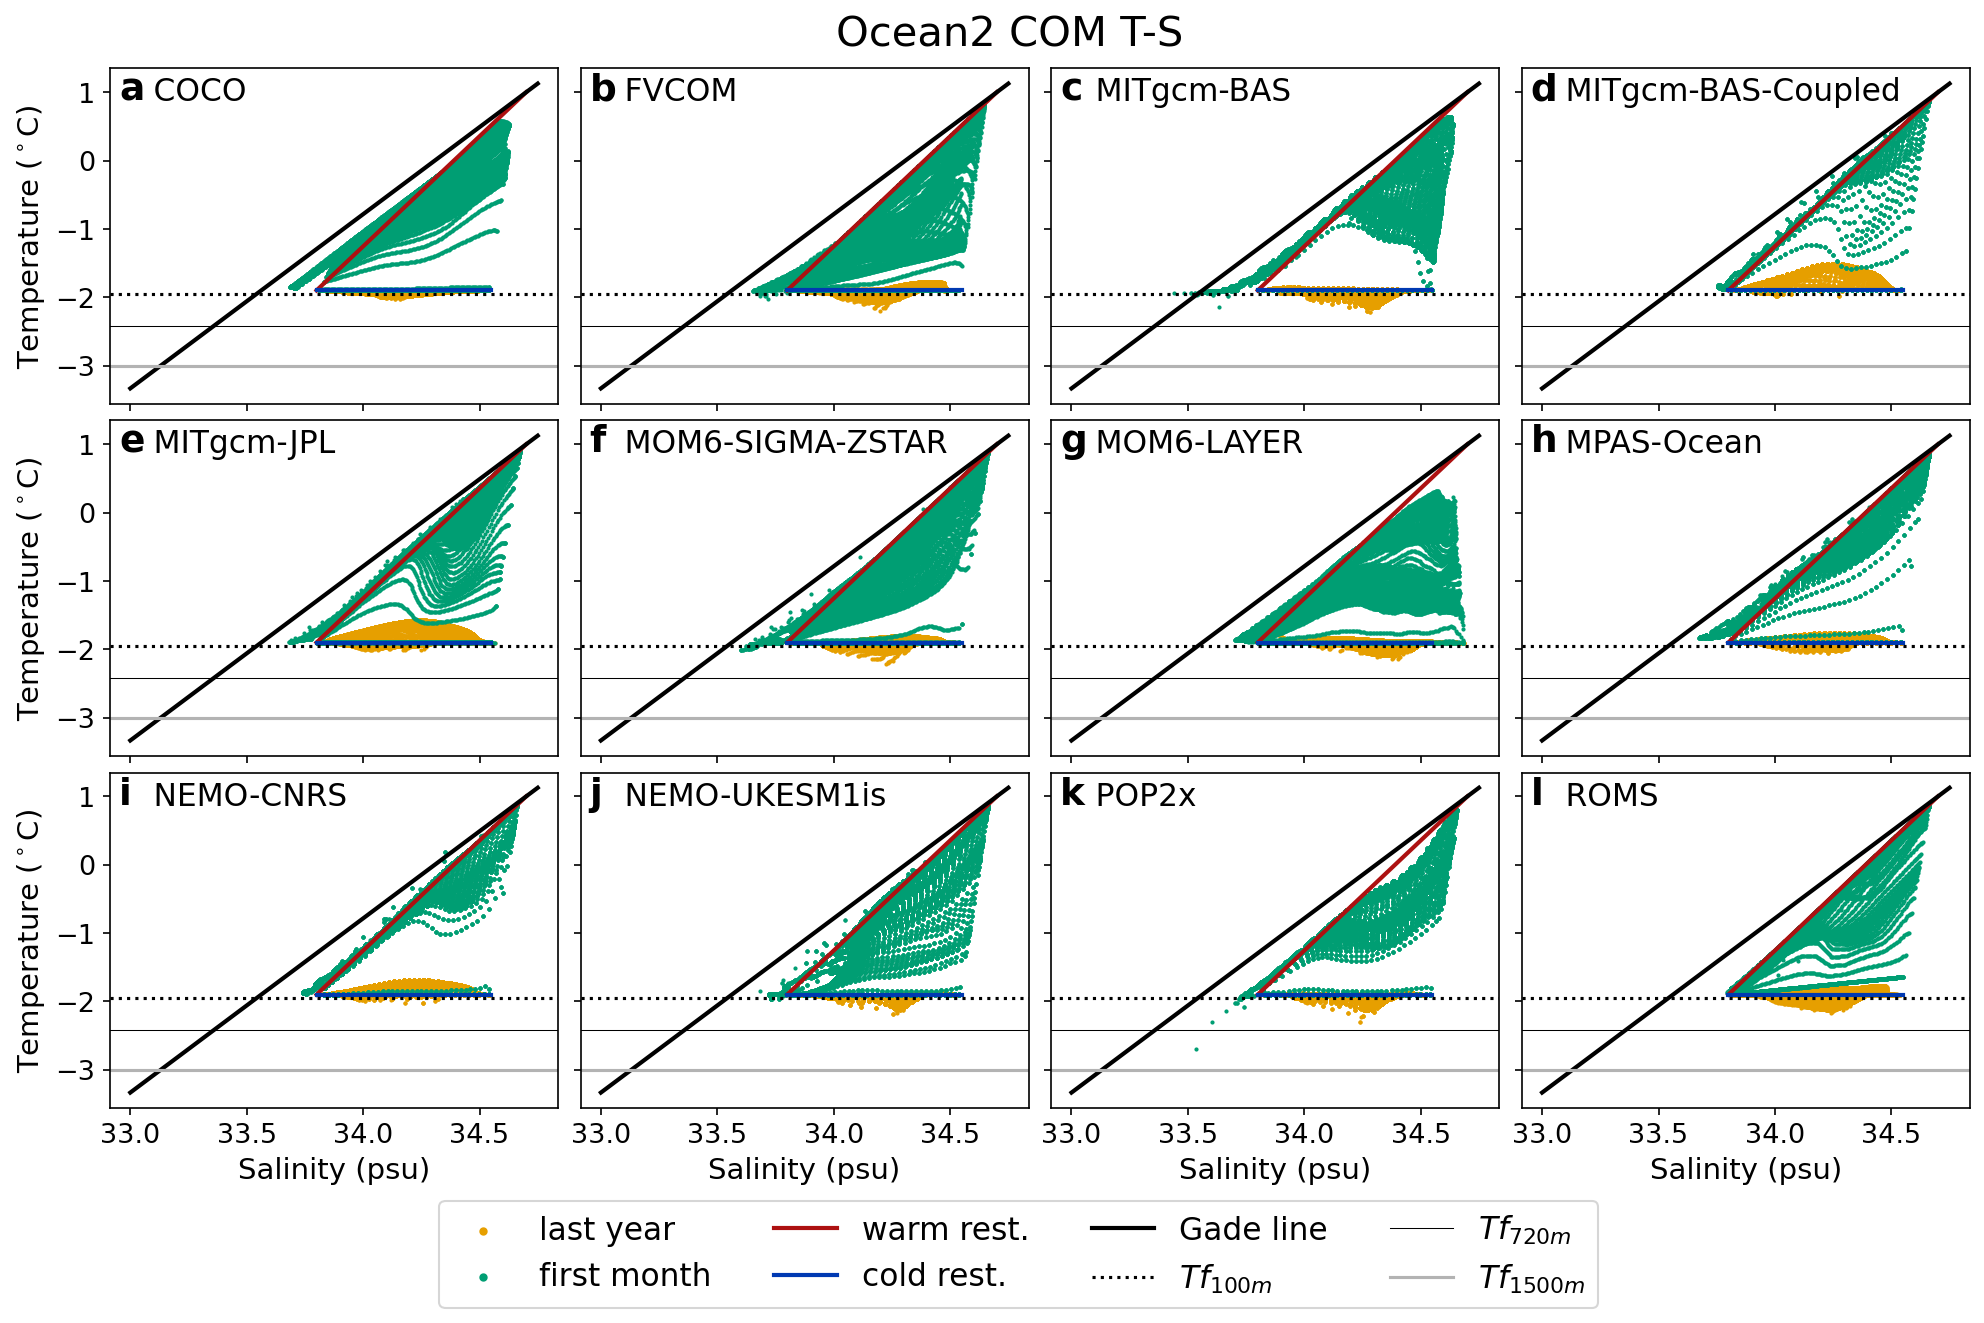

In [8]:
expt = Ocean2_COM

# cold restoring conditions
tc0 = -1.9
tc1 = -1.9
sc0 = 33.8
sc1 = 34.55

# warm restoring conditions
tw0 = -1.9
tw1 = 1
sw0 = 33.8
sw1 = 34.7

labels = get_labels(expt)

length = len(expt)
alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m']

fig, axes = plt.subplots(nrows = 3, ncols = 4, sharex=True, sharey=True, figsize=(16, 9),facecolor='w',dpi = 150)
for i in np.arange(length):
#for ax in axes.flat:
    ax = axes.flat[i]
    ds = xr.open_dataset(basedrive+expt[i], decode_times=False)
    # make x and y coordinates
    ds = ds.set_coords(['x', 'y', 'time', 'z'])
    nTime = ds.sizes['nTime']
    T0 = ds.temperatureXZ.isel(nTime=slice(0, 11)).mean('nTime')
    S0 = ds.salinityXZ.isel(nTime=slice(0, 11)).mean('nTime')
    T1 = ds.temperatureXZ.isel(nTime=slice(nTime-12, nTime)).mean('nTime')
    S1 = ds.salinityXZ.isel(nTime=slice(nTime-12, nTime)).mean('nTime')
    # T_XZ < 1e36 is to get rid of fill values.
    T0 = T0.where(T0 < 1e10)
    S0 = S0.where(S0 < 1e10)
    T1 = T1.where(T1 < 1e10)
    S1 = S1.where(S1 < 1e10)
    ax.scatter(
        S1,T1,
        color = '#E69F00', s = 1)
    ax.scatter(
        S1[0],T1[0],
        color = '#E69F00', label = 'last year', s = 1)
    ax.scatter(
        S0,T0,
        color = '#009E73', s = 1)
    ax.scatter(
        S0[0],T0[0],
        color = '#009E73', label = 'first month', s = 1)
    ax.plot(
        (sw0, sw1),(tw0, tw1),
        color = '#AD1111', label = 'warm rest.', linewidth = 2)
    ax.plot(
        (sc0, sc1),(tc0, tc1),
        color = '#0039B2', label = 'cold rest.', linewidth = 2)
    ax.plot(
        sg,tg,
        color = '#000000', label = 'Gade line', linewidth = 2)
    plt.sca(ax)
  #  plt.axhline(y = tf(s0,0), color = 'k', linestyle = ':', label = '$Tf_{surface}$')
    plt.axhline(y = tf(s0,100), color = 'k', linestyle = ':', label = '$Tf_{100m}$')
    plt.axhline(y = tf(s0,720), color = 'k', linestyle = '-', label = '$Tf_{720m}$', linewidth = 0.5)
    plt.axhline(y = tf(s0,1500), color = [0.7, 0.7, 0.7], linestyle = '-', label = '$Tf_{1500m}$')
    plt.text(0.02,0.99,alphabet[i], fontsize = 18, transform=ax.transAxes, fontweight='bold', va='top')
    plt.text(0.01,0.975,'    '+labels[i], fontsize = 15, transform=ax.transAxes, va='top')
    plt.tick_params(labelsize=13)
    #plt.xlim(33.1,34.9)
    #plt.text(33.5,  -3.5,  labels[i])
plt.legend(loc="upper left", fontsize = 15, bbox_to_anchor = (-2.45,-0.23), ncol = 4,markerscale=3.)
axes[0,0].set_ylabel('Temperature ($^\circ$C)', fontsize = 14)
axes[1,0].set_ylabel('Temperature ($^\circ$C)', fontsize = 14)
axes[2,0].set_ylabel('Temperature ($^\circ$C)', fontsize = 14)
axes[2,0].set_xlabel('Salinity (psu)', fontsize = 14)
axes[2,1].set_xlabel('Salinity (psu)', fontsize = 14)
axes[2,2].set_xlabel('Salinity (psu)', fontsize = 14)
axes[2,3].set_xlabel('Salinity (psu)', fontsize = 14)

#plt.savefig("gade_line_Ocean1_COM.png", bbox_inches='tight')
fig.subplots_adjust(hspace = 0.05,wspace = 0.05)
fig.suptitle('Ocean2 COM T-S', y=0.92,fontsize = 20);
plt.show()